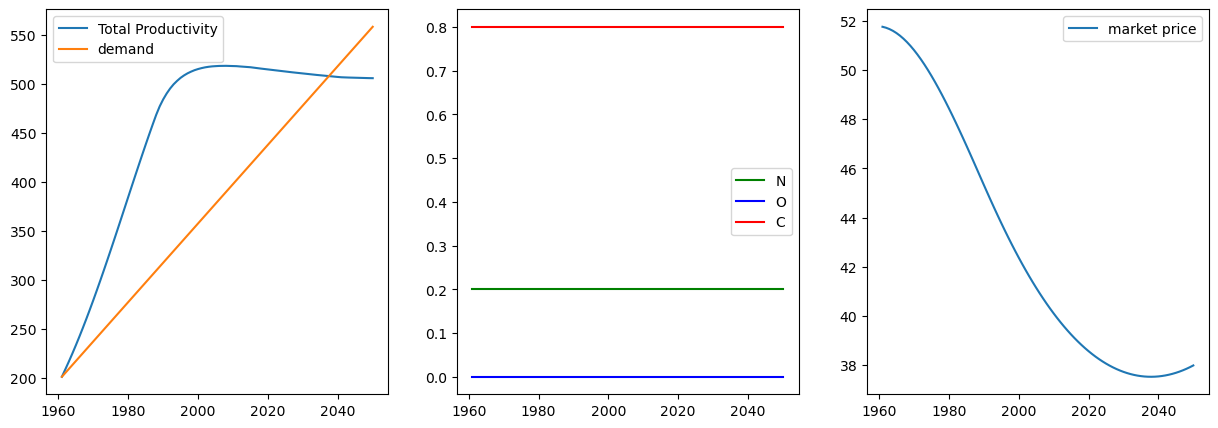

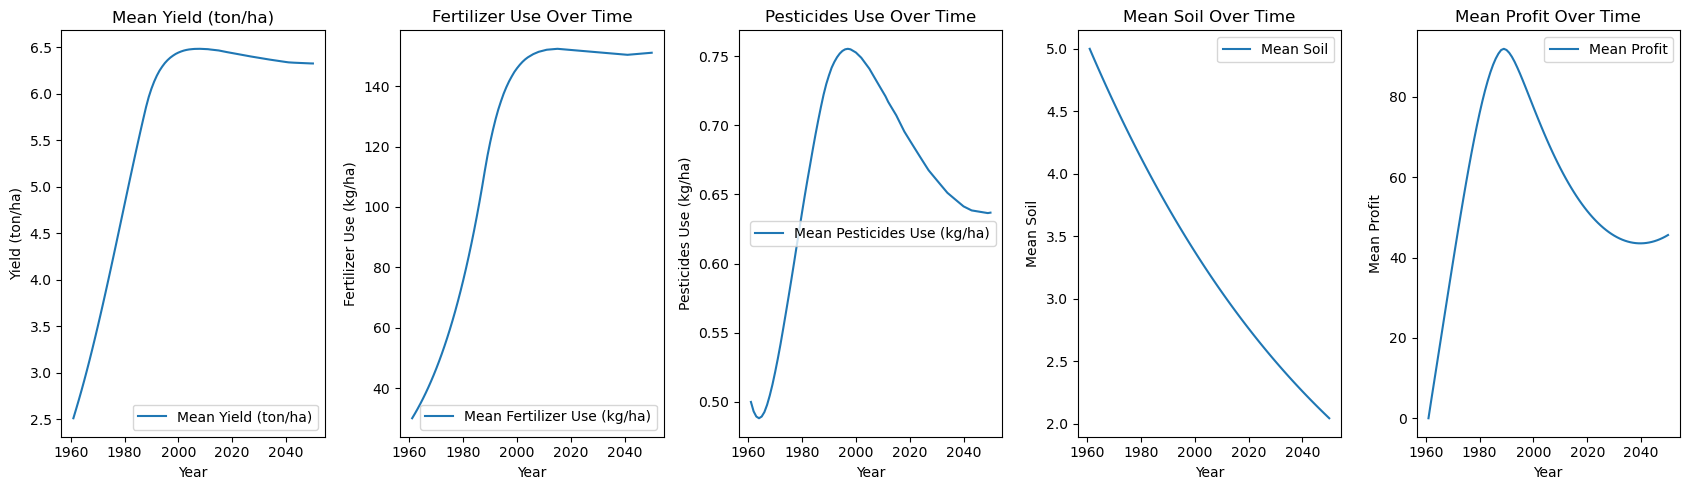

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd

np.random.seed(42)

class Landscape:
    def __init__(self, size, frac_conventional, frac_organic, frac_natural, initial_fertilizer = 10, initial_pesticides = 0.5, mean_soil_health_agri = 1, std_soil_health_agri = 0,\
                 y_max = 8, Nutrient_uptake_efficiency = 1, Nutrient_release_SOM = 30, N_req = 70, \
                    Maximum_Pest_impact = 0.2, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 0.5, \
                        SOM_rate_conventional = -.02, SOM_rate_organic = 0.025, SOM_rate_natural = 0.05, biodiversity_organic = 0.05, \
                            Fertilizer_price = 1, Pesticide_price = 30, fixed_cost_conventional = 500, Fertilizer_choice_profit_impact = 0.2, Fertilizer_choice_other_farmer = 0.1, threshold_base = 0.1, \
                                subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0
                                        ):
            
        self.size = size

        # Environmental variables
        self.y_max = y_max # Maximum Yield [ton/ha]
        self.Nutrient_uptake_efficiency = Nutrient_uptake_efficiency # Nutrient uptake efficiency 
        self.Nutrient_release_SOM = Nutrient_release_SOM # Nutrient release from SOM decomposition [Kg/ha]
        self.N_req = N_req # Nutrient requirement for growth [ton/ha]
        self.Maximum_Pest_impact = Maximum_Pest_impact # Maximum pest impact 
        self.biodiversity_vs_pesticides_protection = biodiversity_vs_pesticides_protection # Protection potential of biodiversity vs pesticides
        self.Pesticides_required = Pesticides_required # Required Pesticides [kg]
        self.SOM_rate_conventional = SOM_rate_conventional # SOM decomposition rate under conventional farming
        self.SOM_rate_organic = SOM_rate_organic # SOM regeneration rate under organic farming
        self.SOM_rate_natural = SOM_rate_natural # SOM regeneration rate under natural 
        self.biodiversity_organic = biodiversity_organic # Biodiversity contribution from organic

        # Economic variables
        self.Fertilizer_price = Fertilizer_price # Cost per kilogram of fertilizer
        self.Pesticide_price = Pesticide_price # Cost per kilogram of pesticide
        self.fixed_cost_conventional = fixed_cost_conventional # Fixed cost for conventional production
        self.Fertilizer_choice_profit_impact = Fertilizer_choice_profit_impact
        self.Fertilizer_choice_other_farmer = Fertilizer_choice_other_farmer
        self.threshold_base = threshold_base # Production switch threshold 

        # Policy variables
        self.subsidy_strength_production = subsidy_strength_production
        self.subsidy_strength_organic = subsidy_strength_organic
        self.policy_strength_natural = policy_strength_natural


        # Initialize matrices
        if frac_conventional + frac_natural + frac_organic != 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic, frac_natural)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri)

        # Calculate initial productivity
        self.pesticides = initial_pesticides * np.ones((size, size))
        self.fertilizer = initial_fertilizer * np.ones((size, size))
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)
        self.initial_productivity = np.sum(self.productivity)
        self.market_demand = self.initial_productivity
        self.market_price = (initial_fertilizer * self.Fertilizer_price + initial_pesticides * self.Pesticide_price + self.fixed_cost_conventional)/np.mean(self.productivity[self.land_type != 'N']) #self.fixed_cost_conventional / np.mean(self.productivity[self.land_type != 'N']) if np.mean(self.productivity[self.land_type != 'N']) > 0 else 0
        self.profits = np.zeros((self.size, self.size)) # (self.land_type != 'N') * (self.market_price * self.productivity - self.fertilizer * self.Fertilizer_price - self.fixed_cost_conventional)
        self.wealth = np.zeros((self.size, self.size)) + self.profits

        # Initialize data for plotting
        self.data = {'total_productivity': [], 'demand': [], 'O': [], 'C': [], 'N':[], 'market_price': [], 'total_economic_value': [], 'land_type_changes': [], \
                     'mean_Y': [], 'std_Y': [], 'mean_F':[], 'std_F':[], 'mean_P': [], 'std_P':[], 'mean_Soil':[], 'std_Soil':[], 'mean_Profit':[], 'std_Profit':[] }

    def initialize_land_types(self, frac_conventional, frac_organic, frac_natural):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['C'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, mean, std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(mean, std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type == 'N'] = 1

        return soil_health, biodiversity
    
    def update_soil_health(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta_h = np.where(self.land_type == 'O', self.SOM_rate_organic, self.SOM_rate_conventional)
        delta_h[self.land_type == 'N'] = self.SOM_rate_natural
        self.soil_health += (delta_h + omega * avg_neighbors) * self.soil_health
        self.land_type[self.soil_health < 0] = 'N'
        self.wealth[self.soil_health < 0] = 0
        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self, omega = 0.):

        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')
        delta_b = np.where(self.land_type == 'O', 0.01, -0.05)
        delta_b[self.land_type == 'N'] = 0.05
        self.biodiversity += (delta_b + omega * avg_neighbors) * self.biodiversity
        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def productionfunction(self, fertilizer, pesticide):
        production =  self.y_max * (1 - np.exp(-1/self.N_req * ( self.soil_health**self.Nutrient_uptake_efficiency * fertilizer + self.Nutrient_release_SOM * self.soil_health))) \
                        * (1 - self.Maximum_Pest_impact * np.exp( - self.biodiversity_vs_pesticides_protection * self.biodiversity - (1 - self.biodiversity_vs_pesticides_protection) * pesticide / self.Pesticides_required)) \
                            * (self.land_type != "N")
        return production
    
    def planning_phase(self):
        expected_market_price = self.market_price
        
        Fertilizer_change = np.linspace(0.5,1.5,20)
        Pest_change = np.linspace(0.5,1.5,20)
        mesh = np.array(np.meshgrid(Fertilizer_change, Pest_change)).T.reshape(-1,2)


        F_try = self.fertilizer * mesh[:,0][:, np.newaxis, np.newaxis]
        P_try = self.pesticides * mesh[:,1][:, np.newaxis, np.newaxis]

        Profit_try = (expected_market_price + self.subsidy_strength_production) * self.productionfunction(F_try, P_try) - self.Fertilizer_price * F_try - self.Pesticide_price * P_try - self.fixed_cost_conventional
        # print(np.max(P_try, axis = 0) * (self.land_type != 'N'))
        F_opt = F_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        P_opt = P_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        # F_opt = self.soil_health**-self.Nutrient_uptake_efficiency * ( - self.N_req * np.log(self.N_req * self.Fertilizer_price / self.market_price / self.y_max) - self.Nutrient_release_SOM * self.soil_health )

        fertilizer = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C'])
        pesticide = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.pesticides + self.Fertilizer_choice_profit_impact * P_opt + self.Fertilizer_choice_other_farmer * np.mean(self.pesticides[self.land_type == 'C'])
        
        return fertilizer * (self.land_type != 'N'), pesticide * (self.land_type != 'N')

    def computeprices(self):
        return (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, np.nan)) / self.productivity

    def compute_sellingmatrix_price(self):
        # Flatten and sort the production values along with their indices
        flattened_productivity = self.productivity.ravel()
        sorted_indices = np.argsort(flattened_productivity)[::-1]
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= self.market_demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= self.market_demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if cumulative_production[meet_demand_index] > self.market_demand:
                sold_fraction[meet_demand_index] = (self.market_demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        else:
            # All units are sold
            sold_fraction[:] = 1

        # Calculate market price
        last_accepted_production = sorted_productivity[meet_demand_index]
        market_price = self.prices.ravel()[sorted_indices][meet_demand_index] / last_accepted_production 

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction
        return reconstructed_matrix.reshape(self.productivity.shape)
    
    def computeprofit(self):
        selling_matrix = self.compute_sellingmatrix_price()
        selling_matrix = np.ones((self.size, self.size))
        self.market_price = self.market_price * (1 + 0.02 *(self.market_demand - np.sum(selling_matrix * self.productivity)) / np.sum(selling_matrix * self.productivity))    
        profit = (self.land_type != 'N') * (selling_matrix * self.productivity * (self.market_price + self.subsidy_strength_production) \
                                            - self.Fertilizer_price * self.fertilizer \
                                                - self.Pesticide_price * self.pesticides \
                                                    + np.where(self.land_type == 'O', self.subsidy_strength_organic, 0) \
                                                        - np.where(self.land_type == 'C', self.fixed_cost_conventional, 0))
        
        return profit
    
    def update_productivity_and_economic_value(self):
        self.fertilizer, self.pesticides = self.planning_phase()
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)        
        self.prices = self.computeprices()
        self.profits = self.computeprofit()
        self.wealth += self.profits
        bankrupt = self.wealth < -1
        # self.land_type[bankrupt] = 'N'
        # self.wealth[bankrupt] = 0

    def switch_farming_technique(self, gamma = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])/8
        organic_neighbors = convolve(self.land_type == 'O', kernel, mode='wrap', output=float)
        conventional_neighbors = convolve(self.land_type == 'C', kernel, mode='wrap', output=float)
        
        threshold_to_organic = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))
        threshold_to_conventional = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))

        exp_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
        exp_profit_conventional = self.expectedprofit(self.market_price, farming_type='C')
        
        switch_to_organic = (self.land_type == 'C') & ( (exp_profit_organic - exp_profit_conventional) / self.fixed_cost_conventional > threshold_to_organic)
        switch_to_conventional = (self.land_type == 'O') & ( (exp_profit_conventional - exp_profit_organic) / self.fixed_cost_conventional > threshold_to_conventional)

        self.land_type[switch_to_organic] = 'O'
        self.land_type[switch_to_conventional] = 'C'


    def introduce_new_farmers(self):
        
        if np.any(self.land_type == 'N'):
            if (self.market_demand - np.sum(self.productivity)) > self.policy_strength_natural:
                # Select candidates
                numbers_of_new_farmers = int(min(np.sum(self.land_type == 'N'), np.ceil((self.market_demand - np.sum(self.productivity)) / np.mean(self.productivity[self.productivity > 0]))))
                candidate_list = np.argwhere(self.land_type == 'N')
                biodiversity_candidates = self.biodiversity[self.land_type == 'N'].ravel()
                probability_list = (1.1 - biodiversity_candidates**self.policy_strength_natural) / np.sum(1.1 - biodiversity_candidates**self.policy_strength_natural)
                candidate_selected = np.random.choice(np.arange(candidate_list.shape[0]), size=numbers_of_new_farmers, p=probability_list, replace=False)
                candidate_matrix = np.full((self.size, self.size), False, dtype=bool)
                candidate_matrix[candidate_list[candidate_selected][:,0], candidate_list[candidate_selected][:,1]]=True
                
                self.land_type[candidate_matrix] = 'C'
                self.wealth[candidate_matrix] = self.fixed_cost_conventional

                # Choose organiv vs conventional
                # expected_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
                # expected_profit_convetional = self.expectedprofit(self.market_price, farming_type='O')
                # prob_1 = (np.sum(self.land_type == 'O')  - np.sum(self.land_type == 'C')) / (np.sum(self.land_type == 'O') + np.sum(self.land_type == 'C'))
                # prob_2 = (expected_profit_organic - expected_profit_convetional)/(expected_profit_convetional + expected_profit_organic)
                # prob_organic = 0.5 + 0.5 * prob_1 * prob_2 
                # organic = np.random.rand(self.size, self.size) < np.array(prob_organic)

                # self.land_type[candidate_matrix * organic] = 'O'
                # self.land_type[candidate_matrix * (1 - organic)] = 'C'

    def update_demand(self):
        self.market_demand += 0.02 * self.initial_productivity 

    def simulate_year(self):
        self.aggregate_data()
        self.update_productivity_and_economic_value()
        self.update_soil_health()
        self.update_biodiversity()
        # self.switch_farming_technique()
        # self.introduce_new_farmers()
        self.update_demand()
        
    def aggregate_data(self):
        self.data['total_productivity'].append(np.sum(self.productivity))
        self.data['demand'].append(self.market_demand)
        self.data['market_price'].append(self.market_price)
        self.data['total_economic_value'].append(np.sum(self.wealth))
        self.data['N'].append(np.sum(self.land_type=='N') / self.size**2)
        self.data['O'].append(np.sum(self.land_type=='O') / self.size**2)
        self.data['C'].append(np.sum(self.land_type=='C') / self.size**2)
        self.data['mean_Y'].append(np.mean(self.productivity[self.land_type!='N']))
        self.data['std_Y'].append(np.std(self.productivity[self.land_type!='N']))
        self.data['mean_F'].append(np.mean(self.fertilizer[self.land_type =='C']))
        self.data['std_F'].append(np.std(self.fertilizer[self.land_type=='C']))
        self.data['mean_P'].append(np.mean(self.pesticides[self.land_type=='C']))
        self.data['std_P'].append(np.std(self.pesticides[self.land_type=='C']))
        self.data['mean_Soil'].append(np.mean(self.soil_health[self.land_type!='N']))
        self.data['std_Soil'].append(np.std(self.soil_health[self.land_type!='N']))
        self.data['mean_Profit'].append(np.mean(self.profits[self.land_type!='N']))
        self.data['std_Profit'].append(np.std(self.profits[self.land_type!='N']))

        # Additional data aggregation can be added here

    def plot_aggregated_data(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        years = np.arange(1961, 1961 + len(landscape.data['mean_F']))

        ax = axes[0]
        ax.plot(years, self.data['total_productivity'], label='Total Productivity')
        ax.plot(years, self.data['demand'], label = 'demand')
        ax.legend()

        ax = axes[1]
        ax.plot(years, self.data['N'], label='N', color='g')
        ax.plot(years, self.data['O'], label='O', color='b')
        ax.plot(years, self.data['C'], label='C', color='r')
        ax.legend()

        ax = axes[2]
        ax.plot(years, self.data['market_price'], label='market price')
        ax.legend()

        plt.show()

    def plot_mean_data(self):
       
        # Plotting
        fig, axes = plt.subplots(1, 5, figsize=(17, 5))
        years = np.arange(1961, 1961 + len(landscape.data['mean_F']))

        # Yield
        ax = axes[0]
        ax.plot(years, self.data['mean_Y'], label='Mean Yield (ton/ha)')
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/crop_yields.csv')
        # condition = (df['country'] == 'France') & (df['year'] >= 1961)
        # ax.plot(df[condition]['year'], df[condition]['wheat_yield'], label ='France', linestyle = '--')

        ax.set_title('Mean Yield (ton/ha)')
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield (ton/ha)')
        ax.legend()

        # Fertilizer Use
        ax = axes[1]
        ax.plot(years, self.data['mean_F'], label='Mean Fertilizer Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Fertilizer Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use (kg/ha)')
        ax.legend()

        # Pesticedes Use
        ax = axes[2]
        ax.plot(years, self.data['mean_P'], label='Mean Pesticides Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Pesticides Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticides Use (kg/ha)')
        ax.legend()

        # Soil Organic Matter
        ax = axes[3]
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2)
        ax.set_title('Mean Soil Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Soil')
        ax.legend()

        # Profits
        ax = axes[4]
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2)
        ax.set_title('Mean Profit Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit')
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.wealth, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        for axes in axs.reshape(-1):
            for (j,i), label in np.ndenumerate(self.land_type):
                axes.text(i,j,label,ha='center',va='center')
                axes.text(i,j,label,ha='center',va='center')

        plt.show()

# Example usage
landscape = Landscape(size=10, frac_conventional = 0.8, frac_organic = 0, frac_natural = 0.2, initial_fertilizer = 30, mean_soil_health_agri = 1, std_soil_health_agri = 0.,\
                        y_max = 8, Nutrient_uptake_efficiency = 0.1, Nutrient_release_SOM = 0, N_req = 70, SOM_rate_conventional = -.01, SOM_rate_organic = 0.025, SOM_rate_natural = 0.05, biodiversity_organic = 0.05, \
                        Fertilizer_price = 0.5, fixed_cost_conventional = 100, Fertilizer_choice_profit_impact = 0.1, Fertilizer_choice_other_farmer = 0.1, threshold_base = 0.1, \
                            subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0.)

# landscape.plot_spatial_data()

for year in range(90):
    if np.all(landscape.land_type != 'N') or np.all(landscape.productivity == 0):
        break
    landscape.simulate_year()




# landscape.plot_spatial_data()
landscape.plot_aggregated_data()
landscape.plot_mean_data()



In [ ]:
1/(-np.log(1-7/8)/(120-5))

57.70780163555854

In [ ]:
len(landscape.data['mean_F'])

100

In [ ]:
import pandas as pd

df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
df.columns

Index(['Entity', 'Code', 'Year',
       'Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'],
      dtype='object')

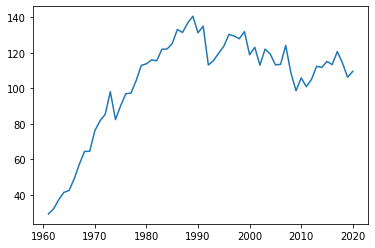

In [ ]:


condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
plt.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'])

In [ ]:
import numpy as np

# Assuming you have the 3D array 'A' from the previous step
# Create a sample 3D array A for demonstration
A = np.array([[[2, 3],
               [4, 5]],
              [[1, 0],
               [2, 2]],
              [[3, 2],
               [1, 3]],
              [[4, 5],
               [0, 1]]])

# Calculate B by squaring each element of A and subtracting 1
B = A**2 - 1

# Find the indices where B is maximum along the z-axis
max_indices_along_z = np.argmax(B, axis=0)

# Extract the corresponding values from A using the indices
max_values_of_A = A[max_indices_along_z, np.arange(A.shape[1])[:, np.newaxis], np.arange(A.shape[2])]

# Now 'max_values_of_A' is a 2D array where each element contains the
# value of A where B is maximum along the z-axis for the corresponding position in A
print(max_values_of_A)


[[4 5]
 [4 5]]


In [ ]:
def plot_agent_based_results(landscape, years):
    # Calculate mean and standard deviation across all farmers for each year
    mean_F = np.mean(landscape['F'], axis=(1, 2))
    std_F = np.std(landscape['F'], axis=(1, 2))

    mean_Y = np.mean(landscape['Y'], axis=(1, 2))
    std_Y = np.std(landscape['Y'], axis=(1, 2))

    mean_S = np.mean(landscape['S'], axis=(1, 2))
    std_S = np.std(landscape['S'], axis=(1, 2))

    mean_P = np.mean(landscape['P'], axis=(1, 2))
    std_P = np.std(landscape['P'], axis=(1, 2))

    mean_s = np.mean(landscape['s'], axis=(1, 2))
    std_s = np.std(landscape['s'], axis=(1, 2))

    # Plotting
    plt.figure(figsize=(14, 5))

    # Fertilizer Use
    plt.subplot(1, 3, 1)
    plt.plot(years, mean_F, label='Mean Fertilizer Use (kg/ha)')
    plt.fill_between(years, mean_F - std_F, mean_F + std_F, alpha=0.2)
    plt.title('Fertilizer Use Over Time')
    plt.xlabel('Year')
    plt.ylabel('Fertilizer Use (kg/ha)')
    plt.legend()

    # Yield
    plt.subplot(1, 3, 2)
    plt.plot(years, mean_Y, label='Mean Yield (t/ha)', color='orange')
    plt.fill_between(years, mean_Y - std_Y, mean_Y + std_Y, alpha=0.2, color='orange')
    plt.title('Yield Over Time')
    plt.xlabel('Year')
    plt.ylabel('Yield (t/ha)')
    plt.legend()

    # Soil Organic Matter
    plt.subplot(1, 3, 3)
    plt.plot(years, mean_S, label='Mean Soil Organic Matter (%)', color='green')
    plt.fill_between(years, mean_S - std_S, mean_S + std_S, alpha=0.2, color='green')
    plt.title('Soil Organic Matter Over Time')
    plt.xlabel('Year')
    plt.ylabel('Soil Organic Matter (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Second plot for Profit and Subsidies
    plt.figure(figsize=(14, 5))

    # Profit
    plt.subplot(1, 2, 1)
    plt.plot(years, mean_P, label='Mean Profit')
    plt.fill_between(years, mean_P - std_P, mean_P + std_P, alpha=0.2)
    plt.title('Profit Over Time')
    plt.xlabel('Year')
    plt.ylabel('Profit')
    plt.legend()

    # Subsidies
    plt.subplot(1, 2, 2)
    plt.plot(years, mean_s, label='Mean Subsidies', color='purple')
    plt.fill_between(years, mean_s - std_s, mean_s + std_s, alpha=0.2, color='purple')
    plt.title('Subsidies Over Time')
    plt.xlabel('Year')
    plt.ylabel('Subsidies')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
F_try = np.ranom.rand(landsc) * np.linspace(0,+2,200)[:, np.newaxis, np.newaxis]
# print(F_try)
P_try = (expected_market_price + self.subsidy_strength_production) * self.productionfunction(F_try) - self.Fertilizer_price * F_try - self.fixed_cost_conventional
# print(np.max(P_try, axis = 0) * (self.land_type != 'N'))
F_opt = F_try[np.argmax(P_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]

In [ ]:
import numpy as np

# Create a sample 2D array
original_array = np.array([[1, 2],
                           [3, 4]])

# Define the values to add for each z-axis
z_values = np.array([1, 0.5, -0.5, -1])

# Expand the dimensions of original_array along the z-axis
expanded_original_array = original_array[:, :, np.newaxis]

# Create a new 3D array where the inserted axis is the z-axis
new_3d_array = expanded_original_array + z_values

# Now, new_3d_array is a 3D array where the inserted axis corresponds to the z-axis
print(new_3d_array)


[[[2.  1.5 0.5 0. ]
  [3.  2.5 1.5 1. ]]

 [[4.  3.5 2.5 2. ]
  [5.  4.5 3.5 3. ]]]


In [ ]:
f0 = np.ones((5,5)) * 1000
f = f0 * np.linspace(0,+2,3)[:, np.newaxis, np.newaxis]
print(f)


[[[   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]]

 [[1000. 1000. 1000. 1000. 1000.]
  [1000. 1000. 1000. 1000. 1000.]
  [1000. 1000. 1000. 1000. 1000.]
  [1000. 1000. 1000. 1000. 1000.]
  [1000. 1000. 1000. 1000. 1000.]]

 [[2000. 2000. 2000. 2000. 2000.]
  [2000. 2000. 2000. 2000. 2000.]
  [2000. 2000. 2000. 2000. 2000.]
  [2000. 2000. 2000. 2000. 2000.]
  [2000. 2000. 2000. 2000. 2000.]]]


In [ ]:
def productionfunction(self, fertilizer):
    return self.y_max * (1 - np.exp(-1/self.N_req * ( self.soil_health**self.Nutrient_uptake_efficiency * fertilizer + self.Nutrient_release_SOM * self.soil_health))) * (self.land_type != "N")
    

In [ ]:
print(landscape.productionfunction(f[:, ]))
prod = 8 * (1-np.exp(-1/70 * (f + 30 *np.ones((5,5)))))
print(prod)


[[[0.44201524 0.44201524 0.44201524 0.         0.44201524]
  [0.44201524 0.44201524 0.44201524 0.         0.44201524]
  [0.44201524 0.44201524 0.44201524 0.44201524 0.44201524]
  [0.         0.44201524 0.         0.44201524 0.        ]
  [0.44201524 0.44201524 0.44201524 0.44201524 0.44201524]]

 [[6.8634021  6.8634021  6.8634021  0.         6.8634021 ]
  [6.8634021  6.8634021  6.8634021  0.         6.8634021 ]
  [6.8634021  6.8634021  6.8634021  6.8634021  6.8634021 ]
  [0.         6.8634021  0.         6.8634021  0.        ]
  [6.8634021  6.8634021  6.8634021  6.8634021  6.8634021 ]]

 [[7.82907417 7.82907417 7.82907417 0.         7.82907417]
  [7.82907417 7.82907417 7.82907417 0.         7.82907417]
  [7.82907417 7.82907417 7.82907417 7.82907417 7.82907417]
  [0.         7.82907417 0.         7.82907417 0.        ]
  [7.82907417 7.82907417 7.82907417 7.82907417 7.82907417]]]
[[[2.78848754 2.78848754 2.78848754 2.78848754 2.78848754]
  [2.78848754 2.78848754 2.78848754 2.78848754 2.7

In [ ]:
p = 300 * landscape.productionfunction(f) - 0.5 * f - 500
print(p)

In [ ]:
print(f)

[[[   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]]

 [[ 600.  600.  600.  600.  600.]
  [ 600.  600.  600.  600.  600.]
  [ 600.  600.  600.  600.  600.]
  [ 600.  600.  600.  600.  600.]
  [ 600.  600.  600.  600.  600.]]

 [[1200. 1200. 1200. 1200. 1200.]
  [1200. 1200. 1200. 1200. 1200.]
  [1200. 1200. 1200. 1200. 1200.]
  [1200. 1200. 1200. 1200. 1200.]
  [1200. 1200. 1200. 1200. 1200.]]]
